## Text Similarity using Word Embeddings

In this notebook we're going to play around with pre build word embeddings and do some fun calcultations:

In [1]:
%matplotlib inline

import os
from keras.utils import get_file
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(10, 10)

from sklearn.manifold import TSNE
import json
from collections import Counter
from itertools import chain

Using TensorFlow backend.


In [2]:
MODEL = 'GoogleNews-vectors-negative300.bin'
path = get_file(MODEL + '.gz', 'https://s3.amazonaws.com/dl4j-distribution/%s.gz' % MODEL)
if not os.path.isdir('generated'):
    os.mkdir('generated')
    
unzipped = os.path.join('generated', path)
if not os.path.isfile(unzipped):
    with open(unzipped, 'wb') as fout:
        zipper = subprocess.Popen(['7zip'],
                          stdin=open(path),
                          stdout=fout
                         )
        zipper.wait()

In [3]:
model = gensim.models.KeyedVectors.load_word2vec_format(unzipped, binary=True)

In [4]:
model.most_similar(positive=['espresso'])

[('cappuccino', 0.6888186931610107),
 ('mocha', 0.6686208844184875),
 ('coffee', 0.6616826057434082),
 ('latte', 0.6536753177642822),
 ('caramel_macchiato', 0.6491268873214722),
 ('ristretto', 0.6485545635223389),
 ('espressos', 0.6438628435134888),
 ('macchiato', 0.6428250074386597),
 ('chai_latte', 0.6308028697967529),
 ('espresso_cappuccino', 0.6280542612075806)]

Now for the famous equation, what is like woman if king is like man? We create a quick method to these calculations here:

In [5]:
def A_is_to_B_as_C_is_to(a, b, c, topn=1):
    a, b, c = map(lambda x:x if type(x) == list else [x], (a, b, c))
    res = model.most_similar(positive=b + c, negative=a, topn=topn)
    if len(res):
        if topn == 1:
            return res[0][0]
        return [x[0] for x in res]
    return None

In [6]:
A_is_to_B_as_C_is_to('man', 'woman', 'king', 3)

['queen', 'monarch', 'princess']

In [7]:
for country in 'Greece', 'France', 'India', 'China':
    print('%s is the capital of %s' %
         (A_is_to_B_as_C_is_to('Germany', 'Berlin', country), country))

Athens is the capital of Greece
Paris is the capital of France
Delhi is the capital of India
Beijing is the capital of China


Or we can do the same for important products for given companies. Here we seed the products equation with two products, the iPhone for Apple and Starbucks_coffee for Starbucks. Note that numbers are replaced by # in the embedding model:

In [8]:
for company in 'Google', 'IBM', 'Dell', 'Microsoft', 'Lonza':
    products = A_is_to_B_as_C_is_to(
        ['Starbucks', 'Apple'], 
        ['Starbucks_coffee', 'iPhone'], 
        company, topn=3)
    print('%s -> %s' % 
          (company, ', '.join(products)))

Google -> personalized_homepage, app, Gmail
IBM -> DB2, WebSphere_Portal, Tamino_XML_Server
Dell -> Axims, smartphone, Inspiron_##z
Microsoft -> Windows_Mobile, SyncMate, Windows
Lonza -> peptide_synthesis, cGMP_manufacture, GelSite_polymer


Let's do some clustering by picking three categories of items, drinks, countries and sports:

In [25]:
beverages = ['espresso', 'beer', 'vodka', 'wine', 'cola', 'tea']
countries = ['Italy', 'Germany', 'Russia', 'France', 'USA', 'India']
sports = ['soccer', 'handball', 'hockey', 'cycling', 'basketball', 'cricket']

items = beverages + countries + sports
len(items)

18

And looking up their vectors:

In [26]:
item_vectors = [(item, model[item]) 
                    for item in items
                    if item in model]
len(item_vectors)

18

Now use TSNE for clustering:

In [33]:
vectors = np.asarray([x[1] for x in item_vectors])
lengths = np.linalg.norm(vectors, axis=1)
norm_vectors = (vectors.T / lengths).T

tsne = TSNE(n_components=2, perplexity=10, verbose=2).fit_transform(norm_vectors)

[t-SNE] Computing 17 nearest neighbors...
[t-SNE] Indexed 18 samples in 0.001s...
[t-SNE] Computed neighbors for 18 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 18 / 18
[t-SNE] Mean sigma: 0.581543
[t-SNE] Computed conditional probabilities in 0.001s
[t-SNE] Iteration 50: error = 65.8121796, gradient norm = 0.5739394 (50 iterations in 0.012s)
[t-SNE] Iteration 100: error = 58.1140022, gradient norm = 0.0333328 (50 iterations in 0.013s)
[t-SNE] Iteration 150: error = 57.8511581, gradient norm = 0.0595930 (50 iterations in 0.010s)
[t-SNE] Iteration 200: error = 66.3923416, gradient norm = 0.1444317 (50 iterations in 0.009s)
[t-SNE] Iteration 250: error = 61.1587639, gradient norm = 0.0574394 (50 iterations in 0.006s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.158764
[t-SNE] Iteration 300: error = 0.9593746, gradient norm = 0.0011900 (50 iterations in 0.000s)
[t-SNE] Iteration 350: error = 0.6237278, gradient norm = 0.0005582 (50 i

And matplotlib to show the results:

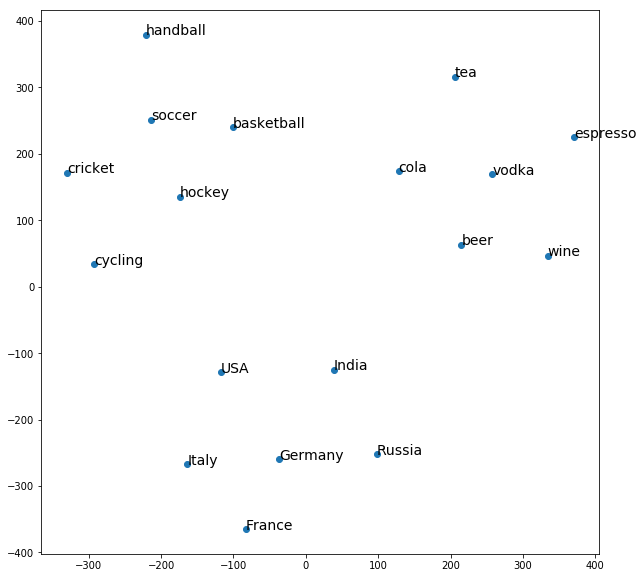

In [34]:
x=tsne[:,0]
y=tsne[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)

for item, x1, y1 in zip(item_vectors, x, y):
    ax.annotate(item[0], (x1, y1), size=14)

plt.show()